In [19]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import pi
from PIL import Image
from pathlib import Path
import warnings

plt.rcParams['axes.axisbelow'] = True

In [20]:
def v0(r,a,b):
    return np.piecewise(r, 
                        [r <= a, (r > a) & (r < b), r >= b], 
                        [lambda r: 0.,  
                        lambda r: np.exp((-4 * np.power((2 * r - a - b), 2)) / (np.power((b - a), 2) - np.power((2 * r - a - b), 2))),
                        lambda r: 0.])


def g(r,a,b):
    return np.piecewise(r, 
                        [r <= a, (r > a) & (r < b), r >= b], 
                        [lambda r: 0.,  
                        lambda r: -(2 * r - a - b) * (a - b) ** 2 / (((b - r) * (a - r)) ** 2),
                        lambda r: 0.])

def s(r,a,b):
    return np.piecewise(r, 
                        [r <= a, (r > a) & (r < b), r >= b], 
                        [lambda r: 0.,  
                        lambda r: 2 * (a - b) ** 2 * (a ** 2 + a * (b - 3 * r) + b ** 2 - 3 * b * r + 3 * r ** 2) / ((a - r) ** 3 * (b - r) ** 3),
                        lambda r: 0.])

def dv0(r,a,b):
    return np.piecewise(r, 
                        [r <= a, (r > a) & (r < b), r >= b],
                        [lambda r: 0.,
                        lambda r: g(r) * v0(r),
                        lambda r: 0.])

def solveWave(T = 3., r_min = 0.0, r_max = 1.8, c = 1.5, a = 0.6, b = 1.2, I = 180, CFL = 0.5, d = 1):
    d = d
    I = I
    r_min = r_min
    r_max = r_max
    c = c
    a = a
    b = b
    i = np.arange(I + 2)
    h = (r_max - r_min) / I
    r_i = np.array([r_min + (iter - 0.5) * h for iter in i])
    CFL = CFL
    tau = CFL * h / c
    t_i = np.arange(0., T, tau)
    u = np.zeros((t_i.size, r_i.size))
    u[0, :] = v0(r_i,a,b)
    v0_i = v0(r_i,a,b)
    g_i = g(r_i,a,b)
    s_i = s(r_i,a,b)
    a_m = [-5./4, 4./3, -1./12]
    
    d2u_t_i = c ** 2 / r_i ** (d - 1) * ((d - 1) * r_i ** (d - 2) * v0_i * g_i + r_i ** (d - 1) * (g_i ** 2 * v0_i + v0_i * s_i))
    u[1, :] = u[0, :] + tau ** 2 * d2u_t_i * 0.5

    for n in range(1, t_i.size - 1):
        for i in range(2, I):
            tmp_sum = 0
            for m in range(3):
                tmp_sum += a_m[m] * (u[n, i - m] + u[n, i + m])
            u[n + 1, i] = 2 * u[n, i] - u[n - 1, i] + (tau * c / h) ** 2 * tmp_sum
        u[n + 1, 0] = u[n + 1, 2]
        u[n + 1, 1] = u[n + 1, 2]
        u[n + 1, -1] = u[n + 1, -3]
        u[n + 1, -2] = u[n + 1, -3]

    return u, r_i, t_i

/var/folders/tx/t_y2r90n5gd84735fqzpxzcr0000gn/T/ipykernel_43088/878973113.py:29: RuntimeWarning: divide by zero encountered in divide
  ratioC = np.linalg.norm(diffs1, axis=1, ord= np.inf) / np.linalg.norm(diffs2, axis=1, ord= np.inf)
/var/folders/tx/t_y2r90n5gd84735fqzpxzcr0000gn/T/ipykernel_43088/878973113.py:30: RuntimeWarning: divide by zero encountered in divide
  ratioL2 = np.linalg.norm(diffs1, axis=1, ord= 2) / np.linalg.norm(diffs2, axis=1, ord= 2)


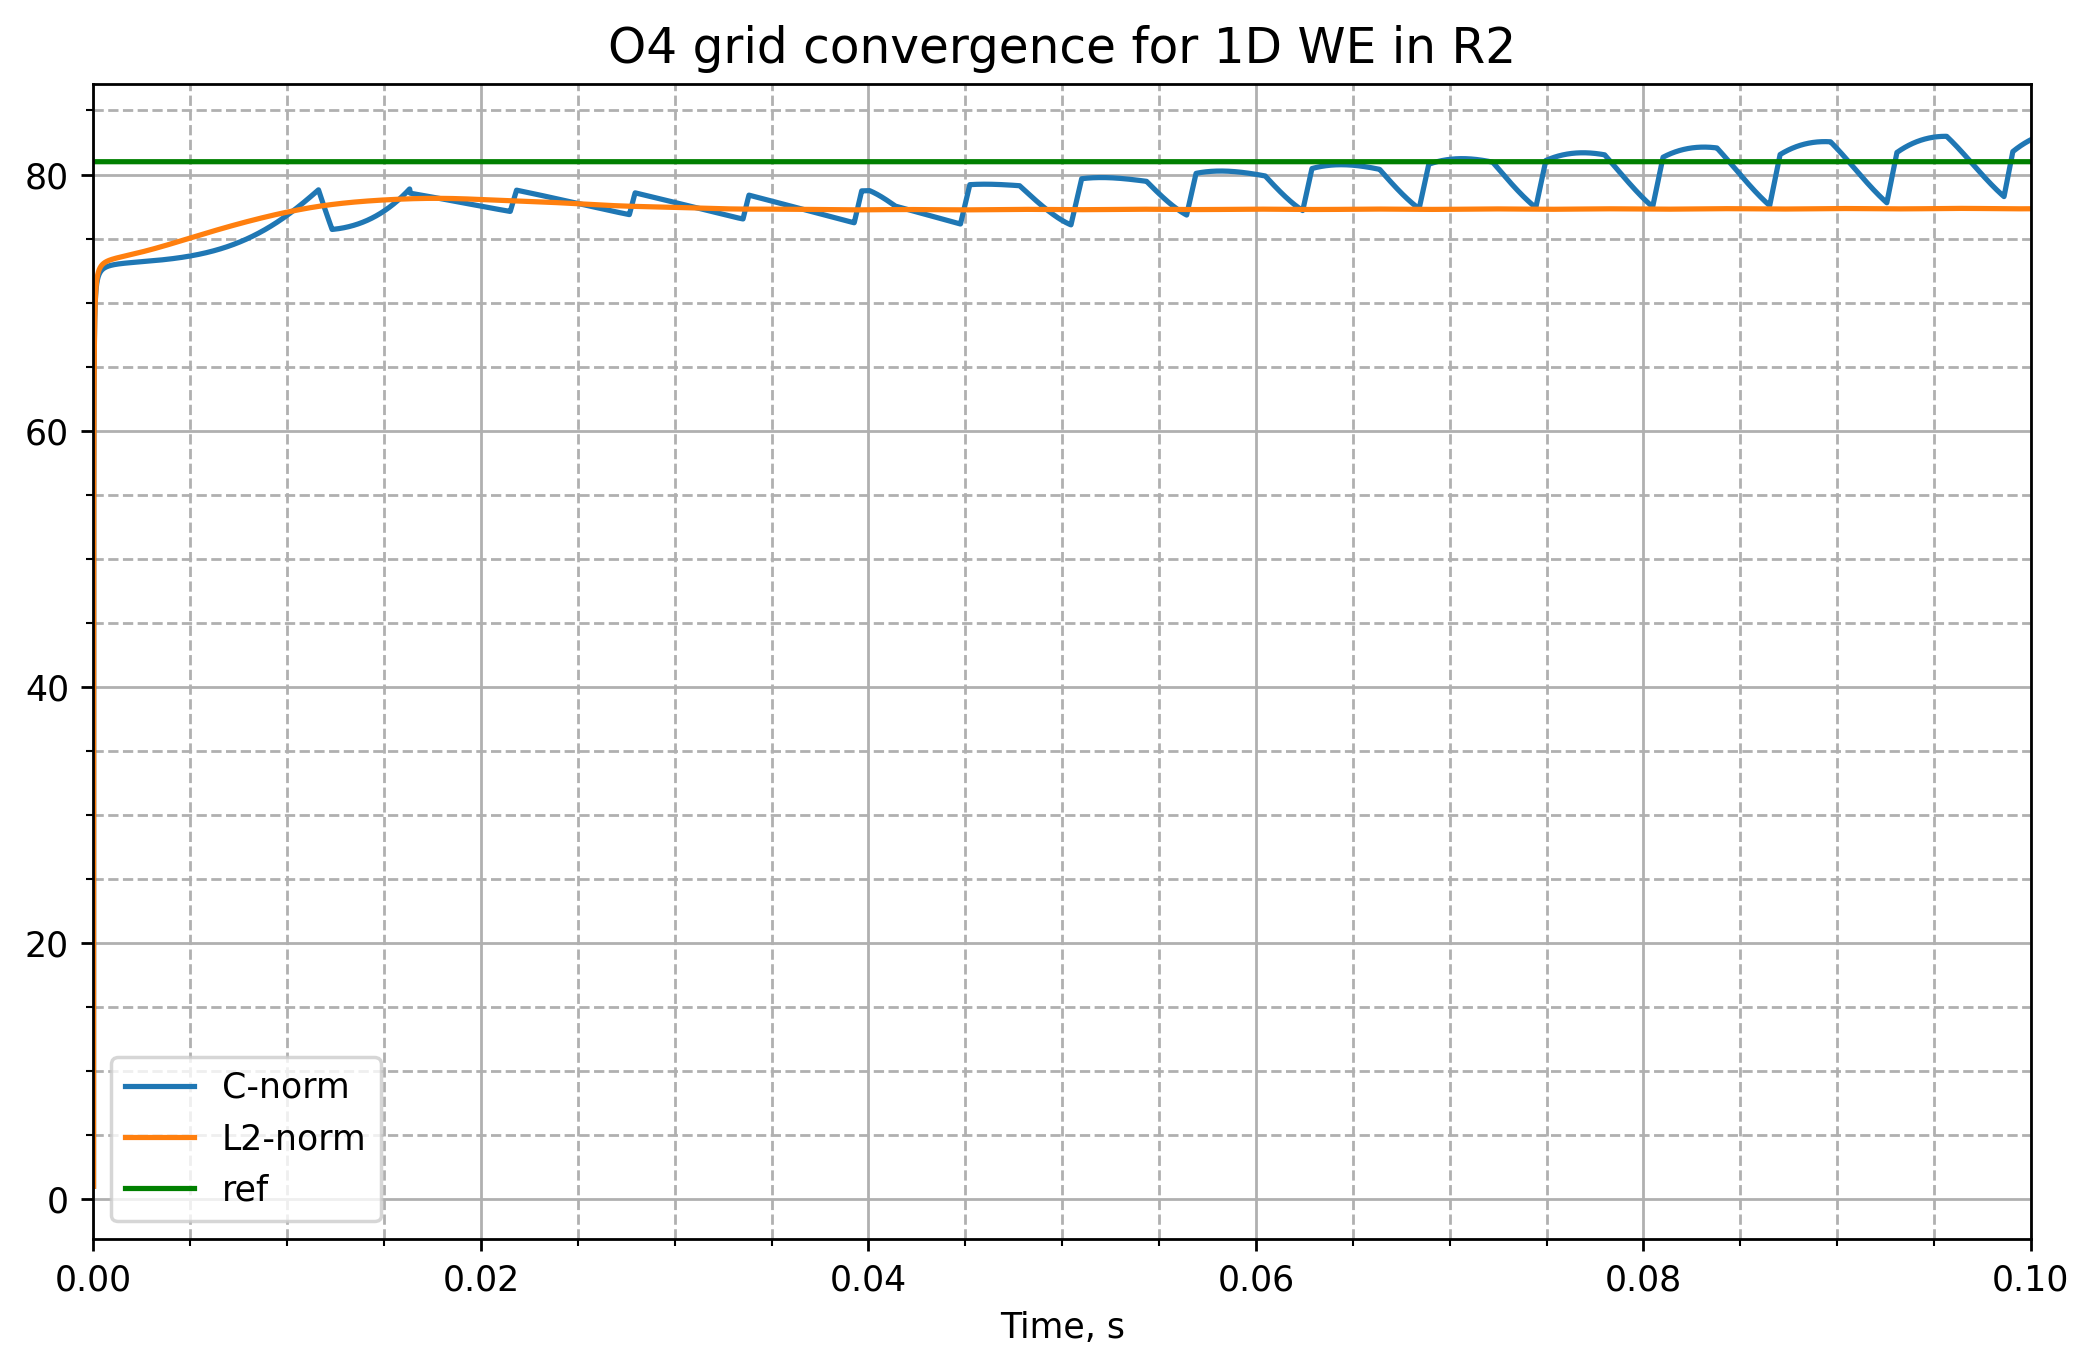

In [22]:
k = 3
base_I = 200
T = 0.1
CFL = 0.001

I1 = base_I
I2 = base_I*k
I3 = base_I*k**2
u1, r1, t1 =solveWave(c= 1.5,I = I1, CFL=CFL,T = T)
u2, r2, t2 =solveWave(c= 1.5,I = I2, CFL=CFL,T = T)
u3, r3, t3 =solveWave(c= 1.5,I = I3, CFL=CFL,T = T)

# DEBUG

# print(np.linalg.norm(t1 - t2[::k]))
# print(np.linalg.norm(t2[::k] - t3[::k**2]))

# print(r1[1:-1].size)
# print(r2[k - 1 : -(k - 1) : k].size)
# print(r3[k**2 - k - 1 : -(k**2 - k - 1) : k ** 2].size)

# print(u1[:, 1:-1].shape)
# print(u2[::k, k - 1 : -(k - 1) : k].shape)
# print(u3[::k**2, k**2 - k - 1 : -(k**2 - k - 1) : k ** 2].shape)

diffs1 = u1[:, 1:-1] - u2[::k, k - 1 : -(k - 1) : k]
diffs2 = u2[::k, k - 1 : -(k - 1) : k] - u3[::k**2, k**2 - k - 1 : -(k**2 - k - 1) : k ** 2]

ratioC = np.linalg.norm(diffs1, axis=1, ord= np.inf) / np.linalg.norm(diffs2, axis=1, ord= np.inf)
ratioL2 = np.linalg.norm(diffs1, axis=1, ord= 2) / np.linalg.norm(diffs2, axis=1, ord= 2)

x = t1
plt.figure(figsize=(10, 6), dpi= 250)
plt.plot(x, ratioC, label= 'C-norm')
plt.plot(x, ratioL2, label= 'L2-norm')
plt.plot(x, np.ones(x.size) * k**4, label= 'ref', c = 'green')
plt.legend()
plt.title(f'O4 grid convergence for 1D WE in R{d}', fontsize=14)
plt.grid(which='major', linestyle='-')
plt.grid(which='minor', linestyle='--')
plt.xlim((0., T))
plt.minorticks_on()
plt.xlabel('Time, s')
plt.savefig(f'./O4-conv-1D.png', 
        transparent = False,  
        facecolor = 'white'
        )